In [126]:
import pandas as pd # packages for reading in data
import numpy as np
import matplotlib.pyplot as plt  # packages for displaying data
from matplotlib.patches import Rectangle
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf #packages for statistics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score,  mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pandas.plotting import lag_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

sns.set_style("darkgrid") # setting style

In [86]:
df = pd.read_csv("../data/chennai_complete.csv",index_col='date',parse_dates=True, # setting the index to datetime
                 usecols=['date','chembarambakkam_water','chembarambakkam_rain']) # selecting columns

## Modeling
---

### Baseline
---

In [185]:
df_dumb = df["chembarambakkam_water"]

In [196]:
values = df_dumb
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
print(dataframe.head(5))

              t  t+1
date                
2004-01-31  NaN  0.0
2004-02-29  0.0  0.0
2004-03-31  0.0  0.0
2004-04-30  0.0  0.0
2004-05-31  0.0  0.0


In [197]:
X = dataframe['t+1']
y= dataframe['t']

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .299, shuffle = False)

In [202]:
test_score = mean_squared_error(y_test, X_test)
print('Test MSE: %.3f' % test_score)

Test MSE: 142919.588


In [206]:
# plt.plot(y_train)
# plt.plot([None for i in y_train] + [x for x in y_test])
# plt.plot([None for i in y_train] + [x for x in X_test])

$$AR(p) \Rightarrow Y_t = \beta_0 + \sum_{k=1}^p \beta_kY_{t-k} + \varepsilon_t$$

In [87]:
df_m= df.resample("m").mean()

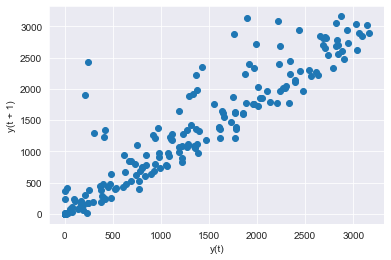

In [88]:
lag_plot(df_m["chembarambakkam_water"])b

In [91]:
adfuller(df_m["chembarambakkam_water"])

(-3.9833081000530304,
 0.0015004816743128208,
 2,
 189,
 {'1%': -3.4654311561944873,
  '5%': -2.8769570530458792,
  '10%': -2.574988319755886},
 2534.8271277324893)

## Data is stationary 

ARIMA models are a subset of linear regression models that attempt to use the past observations of the target variable to forecast its future values.

What the second equation is saying is that the future change in Y is a linear function of the past changes in Y. Why bother with differencing? The reason is that differences are generally much more stationary than the raw undifferenced values. When we do time series modeling, we like our Y variables to be mean variance stationary. This means that the main statistical properties of a model do not vary depending on when the sample was taken. Models built on stationary data are generally more robust.


In [209]:
y = df["chembarambakkam_water"]

y_train, y_test = train_test_split(y, test_size = .299, shuffle = False)

In [210]:
fitted_arima = auto_arima(
    y_train, # data
    start_p = 0,
    start_q = 0,
    max_p = 25,
    max_q = 25,
    stationary = True, # being explicit our original dataset is not stationary
    seasonal= False, # ignoring seasonality (for this lesson...)
    solver='lbfgs', # might change, depending on data
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  #
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2211.823, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1962.327, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2072.025, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2382.567, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1928.318, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1928.582, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1928.525, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1930.182, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1930.427, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1936.653, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.449 seconds


In [102]:
order=(2,0,0)
my_arima = ARIMA(y_train, order = order)
my_ar= my_arima.fit()

In [103]:
my_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                               
=================================================================================
Dep. Variable:     chembarambakkam_water   No. Observations:                  134
Model:                        ARMA(2, 0)   Log Likelihood                -960.159
Method:                          css-mle   S.D. of innovations            310.217
Date:                   Wed, 23 Sep 2020   AIC                           1928.318
Time:                           12:57:38   BIC                           1939.909
Sample:                       01-31-2004   HQIC                          1933.028
                            - 02-28-2015                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        1421.0016    229.041      6.204      0.000     972.090    1869.913
ar.L1.chembarambakkam_water     1.3733      0.075     18.361      0.000       1.227       1.520
ar.L2.chembarambakkam_water    -0.4880      0.076     -6.461      0.000      -0.636      -0.340
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4071           -0.2633j            1.4315           -0.0294
AR.2            1.4071           +0.2633j            1.4315            0.0294
-----------------------------------------------------------------------------
"""

In [104]:
b

In [105]:
y_train

date
2004-01-31       0.000000
2004-02-29       0.000000
2004-03-31       0.000000
2004-04-30       0.000000
2004-05-31       0.000000
                 ...     
2014-10-31     940.548387
2014-11-30    1221.833333
2014-12-31    1081.032258
2015-01-31     931.709677
2015-02-28     690.857143
Freq: M, Name: chembarambakkam_water, Length: 134, dtype: float64

In [106]:
tr_preds

date
2004-01-31    1421.001563
2004-02-29     109.523107
2004-03-31     162.971164
2004-04-30     162.971164
2004-05-31     162.971164
                 ...     
2014-10-31     646.268425
2014-11-30    1154.390175
2014-12-31    1381.944505
2015-01-31    1051.310571
2015-02-28     914.954873
Freq: M, Length: 134, dtype: float64

In [107]:
# getting train predictions using indexing
test_start = len(y_train) # start after training set, hence + 1
test_end   = len(y_train) + len(y_test) - 1 # include full test set
test_preds = my_ar.predict(start = test_start, end = test_end, dynamic = False, typ = "levels")
test_preds.head()

2015-03-31     657.057852
2015-04-30     728.178376
2015-05-31     842.343882
2015-06-30     964.422284
2015-07-31    1076.361366
Freq: M, dtype: float64

In [142]:
plt.figure(figsize=((10, 6)))

plt.title("Average water level by month using in sample predictions")

plt.plot(tr_preds.index, tr_preds, ls='dashed', label= "Training Predictions")

plt.plot(y_train.index, y_train, ls='solid', label='Train Data')

plt.plot(test_preds.index, test_preds, ls= 'dashed', label= "testing predictions")

plt.plot(y_test.index, y_test, ls= 'solid', label = "Test Data")
plt.xlabel("date")

plt.ylabel("water level in millions")

plt.legend(loc = "upper right");


In [ ]:
len(te_preds)

In [109]:
r2_score(y_train[tr_preds.index], tr_preds)

0.8691373774996783

In [110]:
r2_score(y_test[test_preds.index], test_preds)

-0.38778407482371136

In [111]:
np.sqrt(np.sum((y_test[te_preds.index] - test_preds)**2))

7816.396029140491

In [112]:
resids = y_test - test_preds

In [119]:
from pandas import DataFrame

                 0
count   134.000000
mean     -0.570636
std     332.336605
min   -1421.001563
25%    -162.971164
50%     -82.621811
75%      91.471072
max    1948.101733


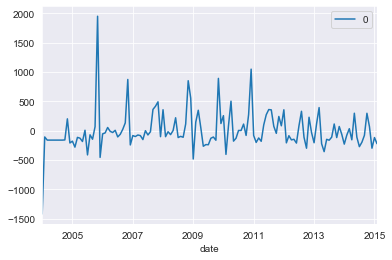

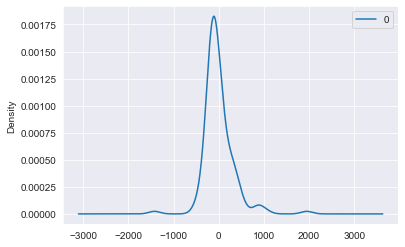

In [121]:
residuals = DataFrame(my_ar.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [ ]:
np.sqrt(np.sum((y_test - np.mean(y_test))**2))

In [113]:
mean_squared_error(y_test, test_preds)


1053380.118695918

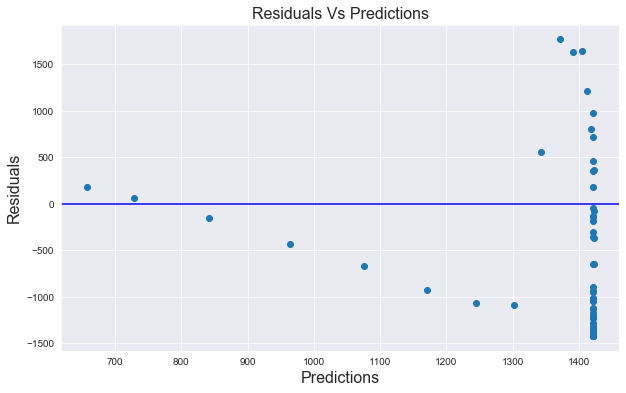

In [114]:
plt.figure(figsize=(10,6)) # determining size
plt.title("Residuals Vs Predictions",fontsize= 16) # plotting title
plt.scatter(test_preds  , resids);
plt.xlabel('Predictions', fontsize= 16) # plotting label
plt.ylabel('Residuals',fontsize= 16) # plotting label
plt.axhline(0, color='Blue');

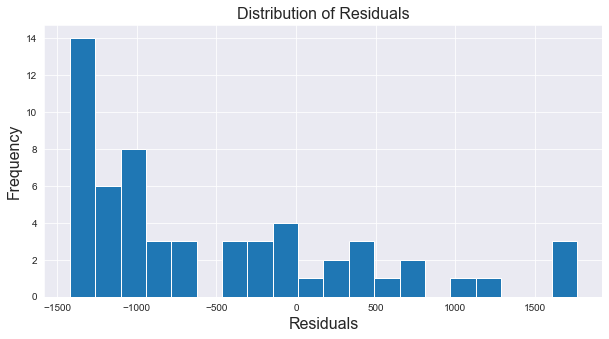

In [115]:
plt.figure(figsize=(10,5)) #determining size
plt.title('Distribution of Residuals',fontsize= 16)
plt.xlabel('Residuals',fontsize= 16)
plt.ylabel('Frequency',fontsize= 16)
plt.hist(resids, bins = 20);

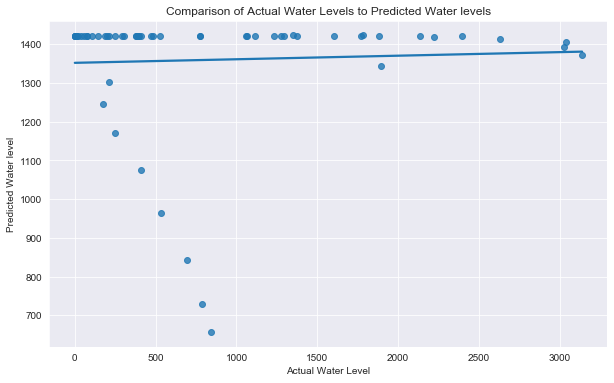

In [122]:
plt.figure(figsize=(10,6))
x = sns.regplot(x= y_test, y= test_preds, ci=None)
x.set(xlabel="Actual Water Level",
      ylabel= "Predicted Water level", 
      title="Comparison of Actual Water Levels to Predicted Water levels");

In [154]:
X = df_m.drop(columns=["chembarambakkam_water","chembarambakkam_rain"])


y = df_m["chembarambakkam_water"]

# we are not shuffling as this is a time-series and the order matters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, shuffle = False)

Similarly to the AR part, we are doing something with historical values here, hence all the lags. But what is this E? E is commonly called error in most explanations of MA models, and it represents the random residual deviations between the model and the target variable (if you’re asking how it’s possible that we can have errors before we’ve even fit the model, hold that thought for just a second).
The full equation of a basic regression model is:

 E represents the difference between the exact answer and the approximately correct answer delivered by our model.

 MLE (Maximum Likelihood Estimation) 

p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values. For example, forecasting that if it rained a lot over the past few days, you state its likely that it will rain tomorrow as well.

This model has an AR number of auto regressin lags 
of 2 

In [127]:
decomposed_result = seasonal_decompose(df["chembarambakkam_water"], model = "additive", period = 4)

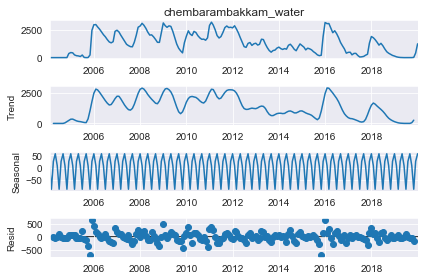

In [129]:
decomposed_result.plot();

In [130]:
df["chembarambakkam_water"].describe()

count     192.000000
mean     1286.661970
std       953.320423
min         0.000000
25%       409.324462
50%      1216.403226
75%      2016.074405
max      3161.903226
Name: chembarambakkam_water, dtype: float64

In [155]:
stepwise_sarima = auto_arima(
    y_train, # data
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
    d = 1, # we know how much to difference, so don't need to waste time searching for this,
    D = 1, # we know how much to difference, so don't need to waste time searching for this,
    seasonal = True, # use seasonality!
    m = 12, # MUST tell which seasonal period to use
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2077.983, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2041.964, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2066.492, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2034.588, Time=0.28 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=2033.019, Time=0.69 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=2052.123, Time=0.20 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=2025.099, Time=0.95 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2027.068, Time=0.40 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=3.81 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=2026.696, Time=1.02 sec
 ARIMA(2,1,1)(3,1,0)[12]             : AIC=2

In [157]:
stepwise_sarima.order

(2, 1, 0)

In [158]:
stepwise_sarima.seasonal_order

(3, 1, 0, 12)

In [134]:
stepwise_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  134
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -862.529
Date:                            Wed, 23 Sep 2020   AIC                           1731.057
Time:                                    15:15:47   BIC                           1739.444
Sample:                                         0   HQIC                          1734.464
                                            - 134                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4468      0.079      5.678      0.000       0.293       0.601
ma.S.L12      -0.7483      0.074    -10.162      0.000      -0.893      -0.604
sigma2      8.414e+04   6882.723     12.225      0.000    7.07e+04    9.76e+04
===================================================================================
Ljung-Box (Q):                       35.11   Jarque-Bera (JB):               167.74
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             1.46
Prob(H) (two-sided):                  0.49   Kurtosis:                         7.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

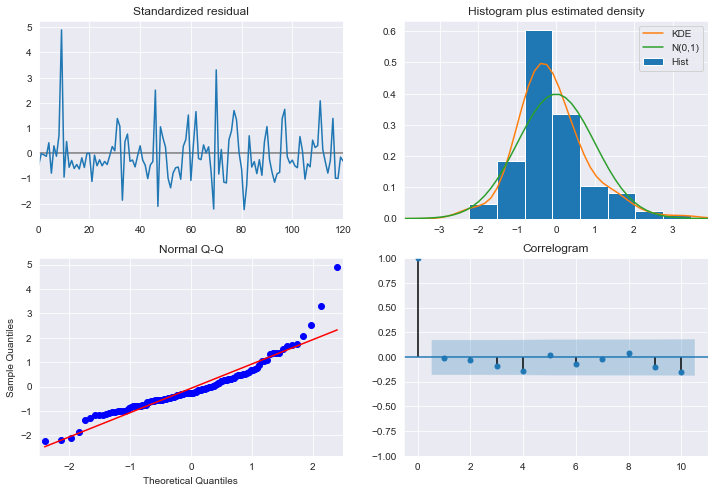

In [135]:
stepwise_sarima.plot_diagnostics(figsize = (12, 8));

In [136]:
order = (2, 1, 1)
seasonal_order = (0, 1, 1, 12)


In [159]:
order = (2, 1,0)
seasonal_order = (3, 1, 0, 12)



# instantiate
water_sarima = SARIMAX(
    y_train, 
    order = order, 
    seasonal_order = seasonal_order, 
    freq = "M", # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

# fit
water_sarima = water_sarima.fit() # stats model returns fitted model

# fit, in case of convergence warning
# fitted_tour_sarima = tour_sarima.fit(maxiter = 

In [160]:
water_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:              chembarambakkam_water   No. Observations:                  153
Model:             SARIMAX(2, 1, 0)x(3, 1, 0, 12)   Log Likelihood                -731.554
Date:                            Wed, 23 Sep 2020   AIC                           1475.109
Time:                                    16:34:27   BIC                           1490.858
Sample:                                01-31-2004   HQIC                          1481.486
                                     - 09-30-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5808      0.101      5.745      0.000       0.383       0.779
ar.L2         -0.3396      0.092     -3.696      0.000      -0.520      -0.160
ar.S.L12      -0.7881      0.130     -6.084      0.000      -1.042      -0.534
ar.S.L24      -0.3648      0.181     -2.021      0.043      -0.719      -0.011
ar.S.L36      -0.1872      0.124     -1.516      0.130      -0.429       0.055
sigma2      9.934e+04   8775.520     11.320      0.000    8.21e+04    1.17e+05
===================================================================================
Ljung-Box (Q):                       51.19   Jarque-Bera (JB):                91.82
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             1.29
Prob(H) (two-sided):                  0.64   Kurtosis:                         6.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [173]:
train_preds = water_sarima.predict(start = 0, end = None, dynamic = False, typ = "levels" )

In [174]:
train_preds

date
2004-01-31       0.000000
2004-02-29       0.000000
2004-03-31       0.000000
2004-04-30       0.000000
2004-05-31       0.000000
                 ...     
2016-05-31    2205.509331
2016-06-30    2476.530373
2016-07-31    1827.419728
2016-08-31    1621.419267
2016-09-30    1190.695642
Freq: M, Length: 153, dtype: float64

In [175]:
test_preds = water_sarima.predict(start = len(y_train), end = len(y_train) + len(y_test) - 1)

In [176]:
test_preds

2016-10-31    1122.675672
2016-11-30    1722.828193
2016-12-31    2004.148424
2017-01-31    1870.753152
2017-02-28    1758.607865
2017-03-31    1822.733634
2017-04-30    1697.994475
2017-05-31    1684.892171
2017-06-30    1519.507435
2017-07-31    1308.826527
2017-08-31    1075.115109
2017-09-30     987.040030
2017-10-31    1081.342272
2017-11-30    2005.367248
2017-12-31    2581.724690
2018-01-31    2455.583932
2018-02-28    2381.041807
2018-03-31    2260.481382
2018-04-30    2043.638998
2018-05-31    2162.277813
2018-06-30    2006.241987
2018-07-31    1752.308465
2018-08-31    1443.550786
2018-09-30    1264.708182
2018-10-31    1379.315928
2018-11-30    2181.394672
2018-12-31    2616.659530
2019-01-31    2486.036884
2019-02-28    2380.021594
2019-03-31    2336.493526
2019-04-30    2155.724814
2019-05-31    2188.391811
2019-06-30    2008.814321
2019-07-31    1780.378100
2019-08-31    1508.537192
2019-09-30    1367.885120
2019-10-31    1450.249187
2019-11-30    2433.776474
2019-12-31  

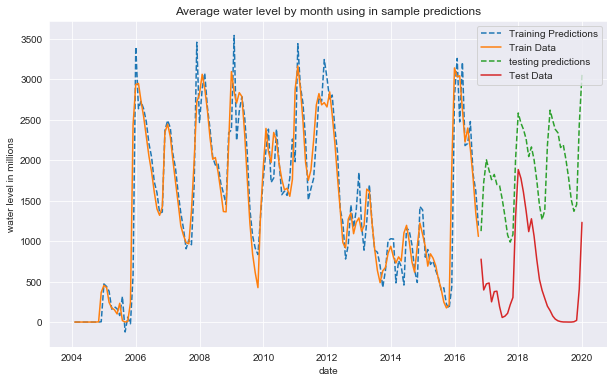

In [177]:
plt.figure(figsize=((10, 6)))

plt.title("Average water level by month using in sample predictions")

plt.plot(train_preds.index, train_preds, ls='dashed', label= "Training Predictions")

plt.plot(y_train.index, y_train, ls='solid', label='Train Data')

plt.plot(test_preds.index, test_preds, ls= 'dashed', label= "testing predictions")

plt.plot(y_test.index, y_test, ls= 'solid', label = "Test Data")
plt.xlabel("date")

plt.ylabel("water level in millions")

plt.legend(loc = "upper right");

In [178]:
mean_squared_error(y_test, test_preds)


2215695.934972939

In [179]:
mean_squared_error(y_train, train_preds)


101439.9952419391